In [1]:
import os
import nnmnkwii.datasets.jvs
from nnmnkwii.io import hts
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pytorch_lightning as pl
import itertools
from matplotlib import pyplot as plt
import pyworld as pw
import pysptk as ps
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# model load

In [2]:
import glob
pa = glob.glob("crosslogs/lightning_logs/version_43/checkpoints/last.ckpt")[-1]

In [3]:
pa

'crosslogs/lightning_logs/version_43/checkpoints/last.ckpt'

In [4]:
from model.crossmodal.main import Model, VQModel
from model.crossmodal.vq.params import params

In [5]:
model = VQModel(params)
model.test_input()

input
torch.Size([64, 1, 36, 40])
torch.Size([64, 3, 32, 32])
encoder out mean_shape
torch.Size([64, 1, 36, 40])


In [6]:
model = model.load_from_checkpoint(pa)
model.eval()

VQModel(
  (ue): UttrEncoder(
    (model): ModuleDict(
      (lr): GLU()
      (conv1a): Conv2d(1, 16, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False, padding_mode=replicate)
      (bn1a): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1b): Conv2d(1, 16, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False, padding_mode=replicate)
      (bn1b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2a): Conv2d(16, 32, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), bias=False, padding_mode=replicate)
      (bn2a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2b): Conv2d(16, 32, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), bias=False, padding_mode=replicate)
      (bn2b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3a): Conv2d(32, 32, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3),

# eval

In [7]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    print(waveform.shape)
    num_channels, num_frames = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [8]:
root = os.path.join("../",  'jvs_r9y9_ver1')
wav_paths = nnmnkwii.datasets.jvs.WavFileDataSource(root, categories=["parallel"])

In [9]:
# 94 95 6 3

In [79]:
x = torchaudio.load(wav_paths.collect_files()[898])[0]
tmp = torchaudio.load(wav_paths.collect_files()[1298])[0]
print(x.shape)
print(tmp.shape)

torch.Size([1, 201752])
torch.Size([1, 202028])


In [61]:
from data.dataset import ImageDataset
idatasets = ImageDataset(root="data/images")

In [12]:
y = idatasets[4]
y2 = idatasets[5]

/work/kenya/splitternet/data/dataset.py:173: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.random.choice(self.data[label][index])
/work/kenya/splitternet/data/dataset.py:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.random.choice(self.data[label][index])


In [13]:
def ex_mc(x):
    f0, sp, ap = pw.wav2world(x.squeeze(0).to(torch.double).numpy(), 24000)
    mc = ps.sp2mc(sp, order=35, alpha=ps.util.mcepalpha(24000))
    mc = torch.from_numpy(mc.T)
    return mc, f0, sp, ap

In [14]:
def synth(mc, f0, ap):
    f0 = f0[:mc.shape[1]]
    ap = ap[:mc.shape[1]]
    mc = mc.T.numpy()
    sp = ps.mc2sp(mc, alpha=ps.util.mcepalpha(24000), fftlen=1024)
    sp = sp.astype(np.double)[:len(f0)]
    return pw.synthesize(f0, sp, ap, 24000)

In [80]:
x_mc, x_f0, x_sp, x_ap = ex_mc(x)
tmp_mc, tmp_f0, tmp_sp, tmp_ap = ex_mc(tmp)

In [16]:
print(x_mc.shape)

torch.Size([36, 1843])


## 元音声の再合成

In [81]:
xx = synth(x_mc, x_f0, x_ap)

In [82]:
import IPython.display
IPython.display.Audio(xx, rate=24000)

/tmp/ipykernel_876295/2825384265.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")


(1, 221160)


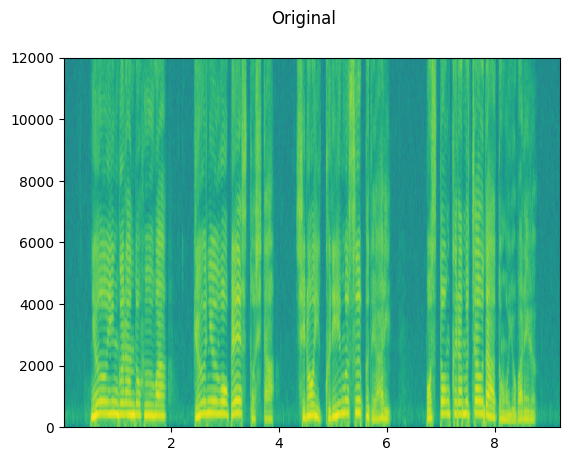

In [19]:
plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")

In [83]:
tmptmp = synth(tmp_mc, tmp_f0, tmp_ap)

In [84]:
import IPython.display
IPython.display.Audio(tmptmp, rate=24000)

(1, 202080)


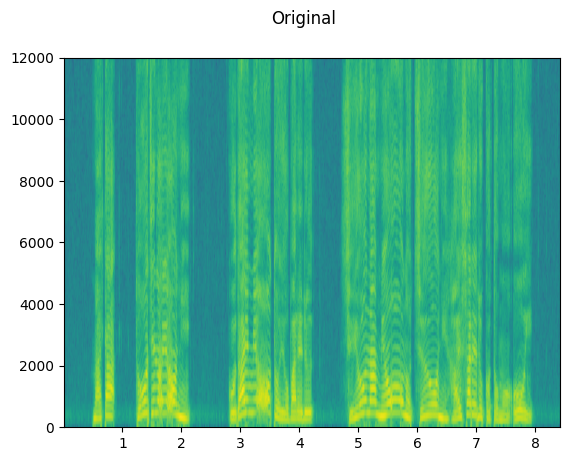

In [71]:
plot_specgram(torch.tensor([tmptmp]), sample_rate=24000, title="Original")

## 元音声の変換再合成

In [23]:
y_mc = model(x_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
y_mc = y_mc.detach()

In [24]:
yy = synth(y_mc, x_f0, x_ap)
yy = yy[2000:-2000]

In [25]:
import IPython.display
IPython.display.Audio(yy, rate=24000)

(1, 216800)


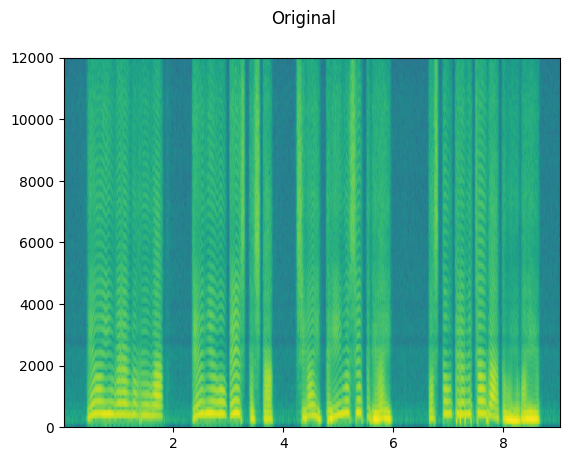

In [26]:
plot_specgram(torch.tensor([yy]), sample_rate=24000, title="Original")

### 2人目

In [27]:
y_mc = model(tmp_mc.unsqueeze(0).unsqueeze(0).to(torch.float), y.unsqueeze(0)).squeeze(0).squeeze(0)
y_mc = y_mc.detach()

In [28]:
y_mc

tensor([[-9.1488e+00, -9.2043e+00, -9.3001e+00,  ..., -9.6150e+00,
         -9.3549e+00, -9.0539e+00],
        [ 1.4770e+00,  1.4350e+00,  1.3334e+00,  ...,  1.0678e+00,
          1.0166e+00,  9.1509e-01],
        [ 7.3653e-01,  6.9755e-01,  6.6068e-01,  ...,  4.2067e-01,
          4.0086e-01,  4.4988e-01],
        ...,
        [-2.2395e-02, -3.8043e-04, -5.2784e-03,  ...,  1.2916e-02,
         -1.2610e-02,  1.7607e-02],
        [ 1.0809e-02, -5.2469e-03,  2.6132e-02,  ...,  9.0298e-03,
         -2.6682e-02, -1.9407e-02],
        [-4.7444e-02, -5.6186e-02, -2.9595e-02,  ..., -2.4826e-02,
         -8.0434e-02,  4.2240e-02]])

In [29]:
yy = synth(y_mc, tmp_f0, tmp_ap)
yy = yy[2000:-2000]

In [30]:
import IPython.display
IPython.display.Audio(yy, rate=24000)

(1, 220160)


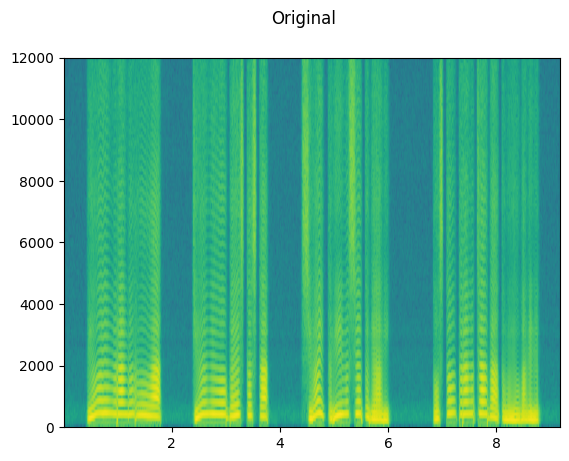

In [31]:
plot_specgram(torch.tensor([yy]), sample_rate=24000, title="Original")

## 画像の再構成確認

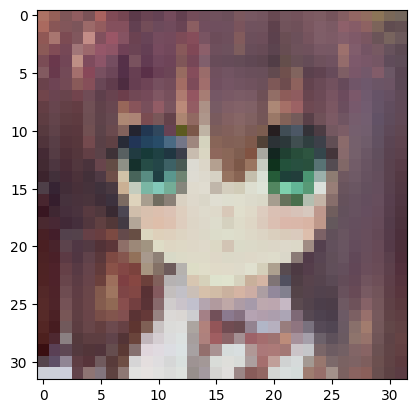

In [32]:
plt.imshow(y.to(torch.uint8).permute(1, 2, 0))

In [40]:
yy = model.rc_image(y.unsqueeze(0))

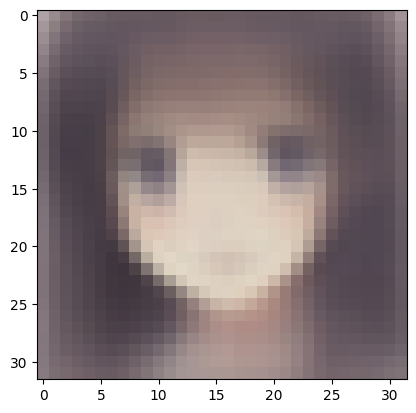

In [41]:
plt.imshow(yy.permute(1, 2, 0))

# メルケプストラム歪み

In [35]:
def calc_melcd(a_mcs, b_mcs):
    """
    input list(np.ndarray)
    """
    m = []
    for a, b in zip(a_mcs, b_mcs):
        min_cost, wp = librosa.sequence.dtw(a[1:, :], b[1:, :])
        m.append(melcd(a[:, wp[:,0]].T, b[:, wp[:,1]].T , lengths=None))
    return sum(m)/ len(a_mcs)

In [36]:
a = x_mc.numpy()
b = tmp_mc.numpy()
calc_melcd([a], [b])

NameError: name 'librosa' is not defined

# データ読み込み

In [ ]:
"""
x, y, z = [], [], []
for i in range(80):
    mx, _, _, _ = ex_mc(torchaudio.load(wav_paths.collect_files()[301+i])[0])
    my, _, _, _ = ex_mc(torchaudio.load(wav_paths.collect_files()[601+i])[0])
    x.append(mx)
    y.append(my)
    if True:
        mz = model(my.unsqueeze(0).unsqueeze(0).to(torch.float), y2.unsqueeze(0)).squeeze(0).squeeze(0)
        mz = mz.detach()
    z.append(mz)
"""

In [ ]:
#calc_melcd(x, y)

In [ ]:
#calc_melcd(x, z)